# Learning Objectives

Use few-shot prompting to build LLM applications for generation tasks.


# Setup

In [ ]:
!pip install -q openai==1.23.2 datasets evaluate bert_score

In [ ]:
import pandas as pd

from openai import OpenAI
from datasets import load_dataset
from google.colab import userdata
from evaluate import load
from tqdm import tqdm

In [ ]:
anyscale_api_key = userdata.get('anyscale_api_key')

In [ ]:
client = OpenAI(
    base_url="https://api.endpoints.anyscale.com/v1",
    api_key=anyscale_api_key
)

In [ ]:
model_name = 'mlabonne/NeuralHermes-2.5-Mistral-7B'

# Text - Text Generation Tasks

## Overview

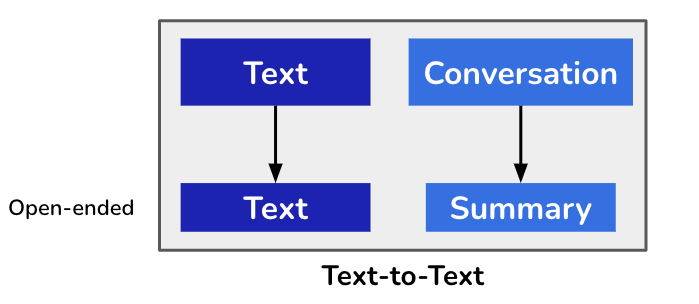

Text-to-Text generation problems are another class of important problems that LLMs solve effectively. In this notebook, we present an approach to design and evaluate prompts for text-to-text tasks using summarization as an example. The approach followed in this notebook can be extended to any other text-to-text task as well.

We begin by presenting a workflow for prompt design and evaluation for text generation tasks.

## Workflow

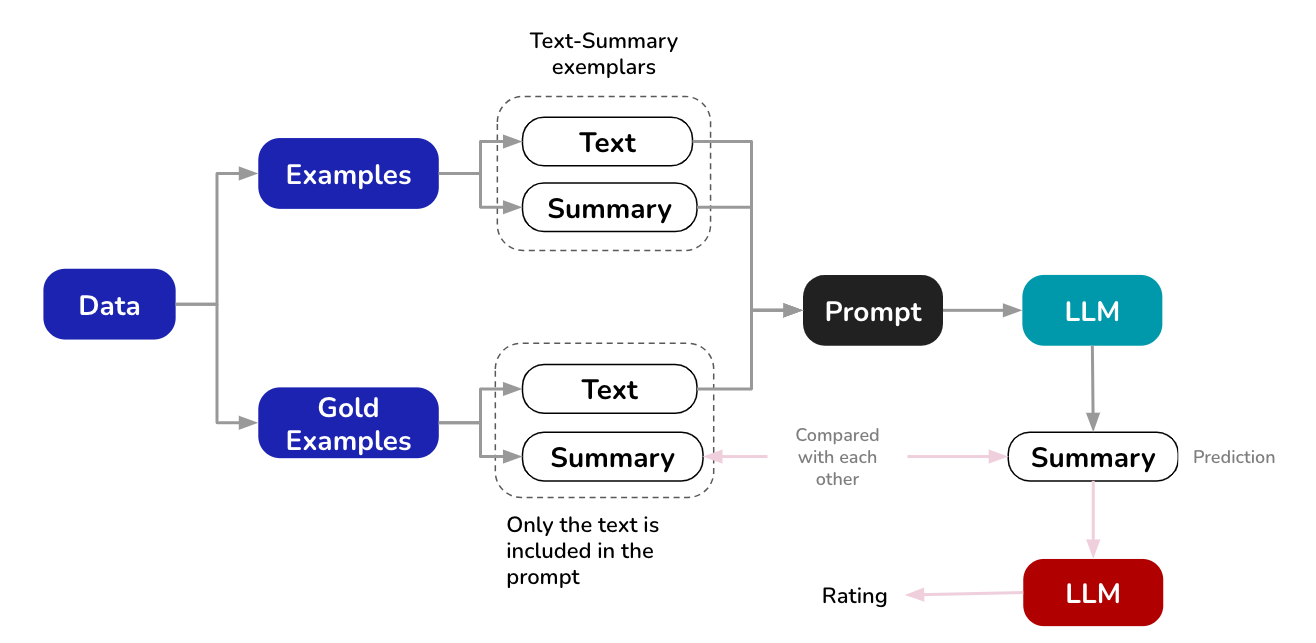

As indicated in the above figure, the data used to achieve text generation tasks comprises examples and gold examples. Examples are input-output exemplars included in the prompt to prime it for expected output generation. Gold examples are inputs for which we have ground truth available and predictions from the LLM for the inputs is compared with the ground truths. We choose the best *prompt* as the one that scores high on predefined metrics on the set of gold examples. Unlike classification though, here we have to contend with subjective output. This complicates the evaluation process (including the difficulty in collecting human generated baselines), and it is common to use LLMs to evaluate the quality of outputs (referred to as LLM-as-a-judge).  

## Evaluation

Given the subjective nature of text generation, there are two ways in which generation tasks could be evaluated.

- When human annotations are available, evaluation is done using BERTScore. BERTScore is an automatic evaluation metric for text generation tasks that leverages the pre-trained contextual embeddings from BERT to compute the semantic similarity between the generated text (candidate) and the reference text, rather than relying on exact token matches.

- When human annotations are not available, we use another LLM to rate the performance of the LLM used in the generation task (see figure below for an example in case of summarization). This method of using LLMs to evaluate LLMs is usualy referred to as LLM-as-a-judge. When LLMs are used to evaluate output, the system message should clearly define the rubrics used for evaluation and the key aspects of the output that should be evaluated. The advantage of using LLMs as judges is that we do not need human baselines (that are costly to collect), while writing down the rubrics for assessment is usually an easier task.

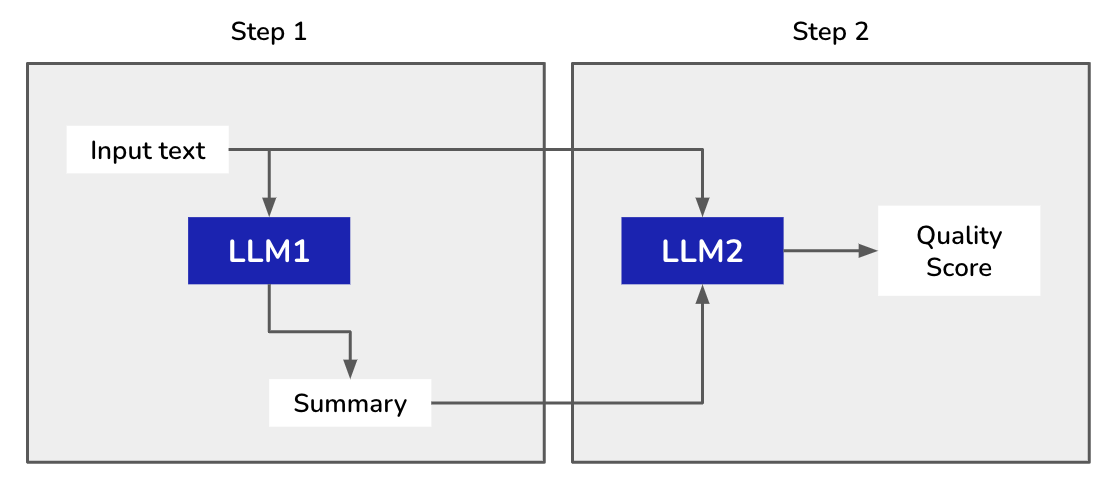

Let us now implement this workflow for diaogue summarization on a sample of conversations.

# Summarization

## Prompt Design

We will design a few-shot prompt for summarization. We first assemble a set of examples (input-output exemplars) as a part of the few-shot prompt. Then we create the prompt in the Anyscale API format.

To evaluate the performance of the *prompt* we will use a set of *gold examples*, that is, a set of examples that is not presented to the model as a part of the prompt.  

**Examples and Gold Examples**

In [ ]:
dataset = load_dataset("pgurazada1/dialogsum")

**Assembling the prompt**

Let us now assemble 4 examples from this dataset of 32 dialogue examples. We also collect the 32 gold examples.

In [ ]:
dialogue_summary_examples_df = dataset['examples'].to_pandas()
dialogue_summary_gold_examples_df = dataset['gold_examples'].to_pandas()

In [ ]:
examples_df = dialogue_summary_examples_df.sample(4)

In [ ]:
examples_df

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [ ]:
for index, row in examples_df.iterrows():
    print('Example Dialogue:')
    print(row[0])
    print('Example Summary:')
    print(row[1])
    break

In [ ]:
system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

In [ ]:
few_shot_prompt = [{'role':'system', 'content': system_message}]

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [ ]:
for index, row in examples_df.iterrows():
    user_input_example = row[0]
    assistant_output_example = row[1]

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': user_input_example
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': assistant_output_example
        }
    )

In [ ]:
few_shot_prompt

We now have 4 examples in the few shot prompt that is ready for use. Before we deploy this prompt, we need to get an estimate of the performance of this prompt. Here is where we need gold examples to get a baseline estimate.

## Evaluation

In [ ]:
predictions, ground_truths = [], []

In [ ]:
for index, row in tqdm(dialogue_summary_gold_examples_df.iterrows()):
    gold_dialogue = row[0]
    gold_summary = row[1]

    user_input = [{'role':'user', 'content': gold_dialogue}]

    response = client.chat.completions.create(
        model=model_name,
        messages=few_shot_prompt + user_input
    )

    predictions.append(response.choices[0].message.content)
    ground_truths.append(gold_summary)

We now have a set of summaries from the LLM and we want to understand if the summary is a good reflection of the content of the dialogue. To accomplish this, we could use a more powerful model to act as a judge. We also have human baseline summaries for the same conversation and we could use BERTScore to compare the predictions and ground truths. Let us now run evaluations using both these methods.

**BERTScore**

In [ ]:
bertscore = load("bertscore")

In [ ]:
results = bertscore.compute(
    predictions=predictions,
    references=ground_truths,
    lang="en"
)

In [ ]:
sum(results['f1'])/len(results['f1'])

The above score indicates that the summarization was of very high quality,

**LLM-as-a-judge**

A general prompt that can be used when LLMs are used as judges is presented below.

In [ ]:
rater_model = "mistralai/Mixtral-8x7B-Instruct-v0.1"

In [ ]:
rater_system_message = """
You are tasked with rating AI-generated summaries of dialogues based on the given metric.
You will be presented a dialogue and an AI generated summary of the dialogue as the input.
In the input, the dialogue will begin with ###Dialogue while the AI generated summary will begin with ###Summary.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the summary.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The summary should cover all the aspects that are majorly being discussed in the dialogue.

Instructions:
1. First write down the steps that are needed to evaluate the summary as per the metric.
2. Give a step-by-step explanation if the summary adheres to the metric considering the dialogues as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the summary using the evaluaton criteria and assign a score.
"""

Notice how the rubric is clearly defined. Also the metric used to judge the output is clearly delineated. This prompt can be readily adapted to create multiple raters,e ach focusing on one metric.

In [ ]:
rater_user_message_template = """
###Dialogue
{dialogue}

###Summary
{summary}
"""

In [ ]:
ratings = []

In [ ]:
for gold_dialogue, prediction in tqdm(zip(dialogue_summary_gold_examples_df.dialogue, predictions)):

    rater_prompt = [
        {'role': 'system',
         'content': rater_system_message
        },
        {
            'role': 'user',
            'content': rater_user_message_template.format(
                dialogue=gold_dialogue,
                summary=prediction
            )
        }
    ]

    response = client.chat.completions.create(
        model=rater_model,
        messages=rater_prompt
    )

    ratings.append(response.choices[0].message.content)

In [ ]:
pd.DataFrame(
    {'dialogue': dialogue_summary_gold_examples_df.dialogue,
     'prediction': predictions,
     'rating': ratings
     }
)

These detailed ratings could be used to diagnose issues with the prompt or the model used.

# Next Steps

After a few-shot prompt is assembled and evaluated, the prompt is wrapped within a server and deployed.

In [ ]:
# @title Dialogue summarizer

dialogue = "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today? #Person2#: I found it would be a good idea to get a check-up. #Person1#: Yes, well, you haven't had one for 5 years. You should have one every year. #Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor? #Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good. #Person2#: Ok. #Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith? #Person2#: Yes. #Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit. #Person2#: I've tried hundreds of times, but I just can't seem to kick the habit. #Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave. #Person2#: Ok, thanks doctor." # @param {type:"string"}

system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

user_input = [{'role':'user', 'content': dialogue}]

few_shot_prompt = [{'role':'system', 'content': system_message}]

for index, row in dialogue_summary_examples_df.sample(4).iterrows():
    example_dialogue = row[0]
    example_summary = row[1]

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': example_dialogue
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': example_summary
        }
    )

response = client.chat.completions.create(
    model=model_name,
    messages=few_shot_prompt + user_input
)

print(response.choices[0].message.content)


In [ ]:
example_dialogue = """
#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today? #Person2#: I found it would be a good idea to get a check-up. #Person1#: Yes, well, you haven't had one for 5 years. You should have one every year. #Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor? #Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good. #Person2#: Ok. #Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith? #Person2#: Yes. #Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit. #Person2#: I've tried hundreds of times, but I just can't seem to kick the habit. #Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave. #Person2#: Ok, thanks doctor.

"""

# Datasets for practise

## Government Reports

In [ ]:
govt_report_data = load_dataset("pgurazada1/govreport")

In [ ]:
govt_report_data

In [ ]:
govt_report_data['examples'].to_pandas().sample(4)

## PII Masking

In [ ]:
pii_mask_data = load_dataset("pgurazada1/pii-masking")

In [ ]:
pii_mask_data

In [ ]:
pii_mask_data['examples'].to_pandas().sample(4)

## Math Instruct

In [ ]:
math_instruct_data = load_dataset("pgurazada1/mathinstruct")

In [ ]:
math_instruct_data

In [ ]:
math_instruct_data['examples'].to_pandas().sample(4)

In [ ]:
math_instruct['train'].to_pandas().sample(32).loc[:, ['instruction', 'output']].to_csv('examples.csv', index=False)
math_instruct['train'].to_pandas().sample(32).loc[:, ['instruction', 'output']].to_csv('gold-examples.csv', index=False)